<a href="https://colab.research.google.com/github/ugurcancakal/network_pytorch/blob/master/WideResNet22_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)


In this tutorial, we'll use the following techniques to achieve over 90% accuracy in less than 5 minutes:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

In [1]:
import os
import torch 
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
# Download the dataset
dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

data_dir = './data/cifar10'

# Look inside the dataset directory
print(os.listdir(data_dir+'/train'))
classes = os.listdir(data_dir + '/train')
print(classes)


['bird', 'automobile', 'horse', 'cat', 'truck', 'airplane', 'dog', 'deer', 'frog', 'ship']
['bird', 'automobile', 'horse', 'cat', 'truck', 'airplane', 'dog', 'deer', 'frog', 'ship']


There are a few important changes we'll make while creating the PyTorch datasets:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.
3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [3]:
# ?torch.mean()

In [4]:
def get_next_image(dataset):
  for i in range(len(dataset)):
    yield dataset[i][0]

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

dataset = ImageFolder(data_dir+'/train', tt.ToTensor())
len(dataset)
image_concat = torch.cat(list(get_next_image(dataset)), dim=2)

In [6]:
# import matplotlib.pyplot as plt
# concat = torch.cat(list(get_next_image(dataset)), dim=2)
# # print(concat)
# plt.imshow(concat.permute(1,2,0))

In [7]:
channels_mean = torch.mean(image_concat, dim = (1,2))
channels_std = torch.std(image_concat, dim = (1,2))
height = dataset[0][0].shape[1]
width = dataset[0][0].shape[2]

In [8]:
print(channels_mean, channels_std, height, width)
# Data transforms (normalization & data augmentation)
train_tfms = tt.Compose([tt.RandomCrop(size = (height, width),
                                      padding = 4,
                                      padding_mode = 'reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(channels_mean, channels_std)])
valid_tfms = tt.Compose([tt.ToTensor(),
                         tt.Normalize(channels_mean, channels_std)])



tensor([0.4915, 0.4823, 0.4468]) tensor([0.2470, 0.2435, 0.2616]) 32 32


In [9]:
# @ugurc

train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

image_concat = torch.cat(list(get_next_image(train_ds)), dim=2)
channels_mean = torch.mean(image_concat, dim = (1,2))
channels_std = torch.std(image_concat, dim = (1,2))
print(channels_mean, channels_std, height, width)

image_concat = torch.cat(list(get_next_image(valid_ds)), dim=2)
channels_mean = torch.mean(image_concat, dim = (1,2))
channels_std = torch.std(image_concat, dim = (1,2))
print(channels_mean, channels_std, height, width)



tensor([-0.0031, -0.0044, -0.0047]) tensor([0.9983, 0.9981, 0.9978]) 32 32
tensor([0.0111, 0.0118, 0.0139]) tensor([0.9985, 0.9976, 1.0000]) 32 32


In [10]:
# # Tutorial -- mine is better
# # tensor([-0.0031, -0.0046, -0.0049]) tensor([1.2193, 1.2190, 1.2989]) 32 32
# # tensor([0.0139, 0.0147, 0.0194]) tensor([1.2192, 1.2181, 1.3015]) 32 32

# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# train_tfms = tt.Compose([tt.RandomCrop(size = (height, width),
#                                       padding = 4,
#                                       padding_mode = 'reflect'),
#                          tt.RandomHorizontalFlip(),
#                          tt.ToTensor(),
#                          tt.Normalize(*stats)])
# valid_tfms = tt.Compose([tt.ToTensor(),
#                          tt.Normalize(*stats)])

# train_ds = ImageFolder(data_dir+'/train', train_tfms)
# valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

# image_concat = torch.cat(list(get_next_image(train_ds)), dim=2)
# channels_mean = torch.mean(image_concat, dim = (1,2))
# channels_std = torch.std(image_concat, dim = (1,2))
# print(channels_mean, channels_std, height, width)

# image_concat = torch.cat(list(get_next_image(valid_ds)), dim=2)
# channels_mean = torch.mean(image_concat, dim = (1,2))
# channels_std = torch.std(image_concat, dim = (1,2))
# print(channels_mean, channels_std, height, width)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


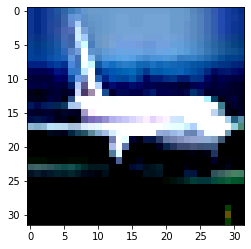

In [11]:
import matplotlib.pyplot as plt
# print(concat)
plt.imshow(train_ds[3][0].permute(1,2,0))

In [12]:
from torch.utils.data import DataLoader

In [13]:
batch_size  = 256

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=8, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle = True,
                      num_workers=8, pin_memory=True)

In [15]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [16]:
def show_batch(dl):
   for images,labels in dl:
     fig,ax = plt.subplots(figsize=(16,16))
     ax.set_xticks([])
     ax.set_yticks([])
     ax.imshow(make_grid(images[:100], 10).permute(1,2,0))
     break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


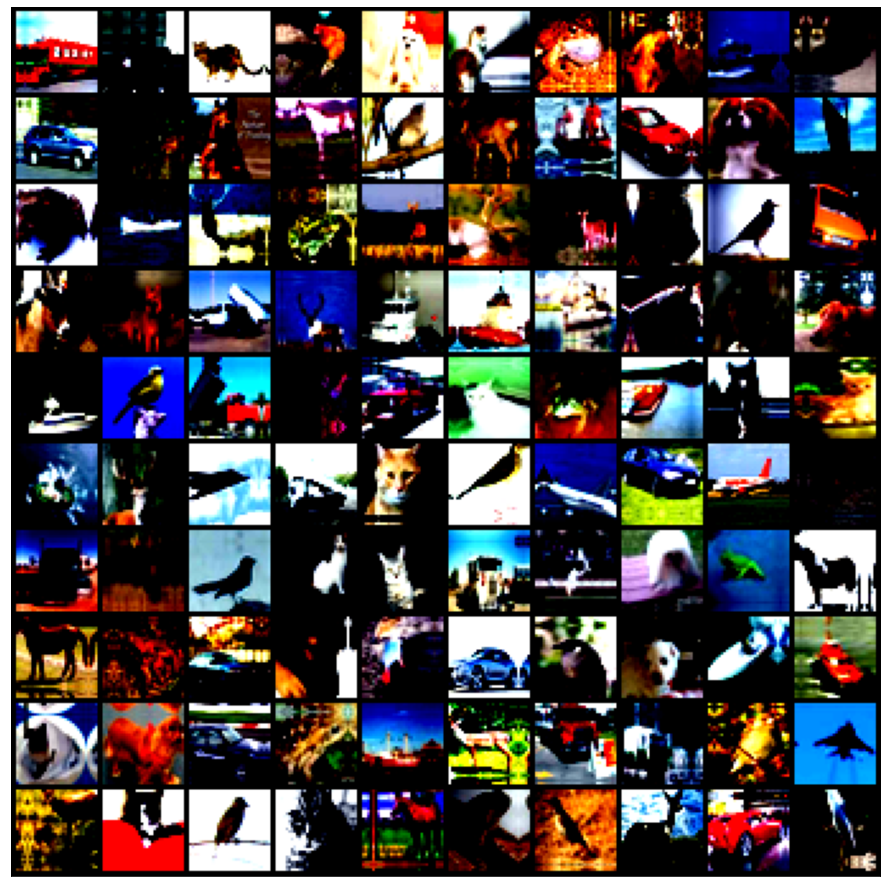

In [17]:
show_batch(train_dl)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simply Residual block:

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3,
                           stride = 1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3,
                           stride = 1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out + x)


In [20]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break

torch.Size([256, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the WideResNet22 network which has the following structure 

![alternatif metin](https://miro.medium.com/max/2500/1*gOyiFYGHMAEDlyoAIhkWkA.png)

1x1 convolution is used to increase number of channels without mixing the pixels

,2 in yellow convs means stride 2 instead of max pooling

In [21]:
# Helper Functions 
def conv_2d(ni, nf, stride = 1, ks = 3):
  return nn.Conv2d(in_channels = ni, out_channels = nf,
                   kernel_size = ks, stride = stride,
                   padding = ks//2, bias = False)
  
def bn_relu_conv(ni,nf):
  return nn.Sequential(nn.BatchNorm2d(ni),
                       nn.ReLU(inplace=True),
                       conv_2d(ni,nf))
  
class ResidualBlock(nn.Module):
  def __init__(self, ni, nf, stride = 1):
    super().__init__()
    self.bn = nn.BatchNorm2d(ni)
    self.conv1 = conv_2d(ni, nf, stride)
    self.conv2 = bn_relu_conv(nf, nf)
    self.shortcut = lambda x: x
    if ni!=nf:
      self.shortcut = conv_2d(ni, nf, stride, 1)
  
  def forward(self, x):
    x = F.relu(self.bn(x), inplace=True)
    r = self.shortcut(x)
    x = self.conv1(x)
    x = self.conv2(x) * .2
    return x.add_(r)

In [22]:
def make_group(N, ni, nf, stride):
  start = ResidualBlock(ni,nf,stride)
  rest = [ResidualBlock(nf,nf) for j in range (1,N)]
  return [start] + rest

class Flatten(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x.view(x.size(0), -1)

class WideResNet(nn.Module):
  def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
    super().__init__()
    # Increase channels to n_start using conv layer
    layers = [conv_2d(3,n_start)]
    n_channels = [n_start]

    for i in range(n_groups):
      n_channels.append(n_start*(2**i)*k)
      stride = 2 if i>0 else 1
      layers += make_group(N, n_channels[i],
                           n_channels[i+1], stride)
      
    # Pool, flatten & add linear layer for classification
    layers += [nn.BatchNorm2d(n_channels[-1]),
               nn.ReLU(inplace = True),
               nn.AdaptiveAvgPool2d(1),
               Flatten(),
               nn.Linear(n_channels[-1], n_classes)]

    self.features = nn.Sequential(*layers)

  def forward(self, x):
    return self.features(x)

def wrn_22():
  return WideResNet(n_groups=3, N=3, n_classes=10, k = 6)



In [23]:
model = wrn_22()

In [24]:
print(model)

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [25]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = model(images)
  print('out.shape: ', out.shape)
  break

images.shape:  torch.Size([256, 3, 32, 32])
out.shape:  torch.Size([256, 10])


# Training the model

FastAI library will be used.

**Learning Rate Scheduling**

Learning rate scheduling refers to the process of dynamically changing the learning rate while the model is being trained. There are many strategies for changing the learning rate during training, and the one we'll use is called the 1-cycle policy. We start out with a low learning rate, then gradually increase it linearly to hihg value for about half of the training, and then slowly bring it to the original value. At the end, we train for few iterations with a very low learning rate.

![scheduling](https://sgugger.github.io/images/art5_lr_schedule.png)

Important
https://sgugger.github.io/the-1cycle-policy.html

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [26]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [27]:
data = DataBunch.create(train_ds, valid_ds, bs = batch_size, path = './data/cifar10')
# DataBunch Automatically converts them to data loaders and 
# moves to GPU if there is an available GPU
learner = Learner(data, model, loss_func=F.cross_entropy, metrics = [accuracy])
# learner uses adam optimizer by default
learner.clip = .1 # gradient clipping - limits the value of gradient 

The statement `learner.clip = .1` is used to perform gradient clipping i.e. limits the values of gradients to the range `[-.1, .1]`, thus preventing the undesirable changes in the parameters (weights and biases) due to large gradient values. FastAI also provides a helpful learning rate finder which tries a range of learning rates and helps you select a good learning rate by looking at the graph of loss vs. learning rate

In [28]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


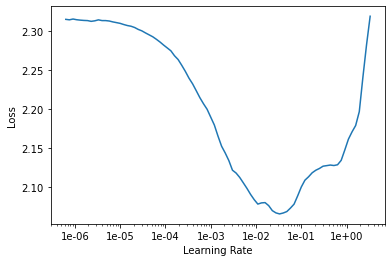

In [29]:
learner.recorder.plot()

Based on the above graph, it seems like a learning rate of 5e-3 lead to the fastest reduction in loss. Good way to pick a good learning rate is to find the point where the descent is the steepest(model is training the fastets)

To train the model using the 1-cycle policy, we use the `.fit_one_cycle` method and pass in the no. of epochs and the maximum learning rate. We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function

In [30]:
learner.fit_one_cycle(cyc_len=9, max_lr=5e-3, wd=1e-4) 
# cyc_len determines the number of epochs
# weight decay not to dominate

epoch,train_loss,valid_loss,accuracy,time
0,1.250524,1.760071,0.460100,01:45
1,0.939238,1.363876,0.595900,01:45
2,0.731425,0.696166,0.754700,01:45
3,0.577712,0.596294,0.793500,01:45
4,0.464763,0.517133,0.827800,01:44
5,0.375208,0.401501,0.864000,01:45
6,0.277004,0.316528,0.892200,01:44
7,0.213698,0.271617,0.911300,01:44
8,0.177455,0.264448,0.913600,01:44


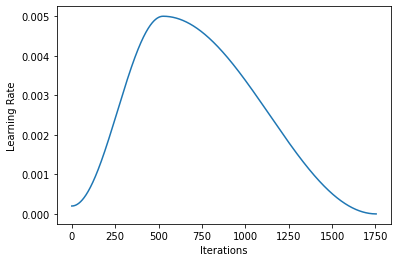

In [31]:
learner.recorder.plot_lr()

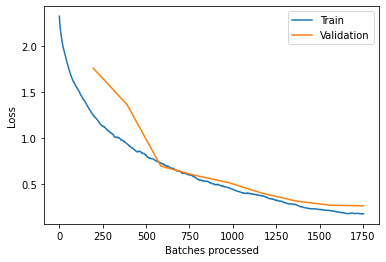

In [34]:
learner.recorder.plot_losses()

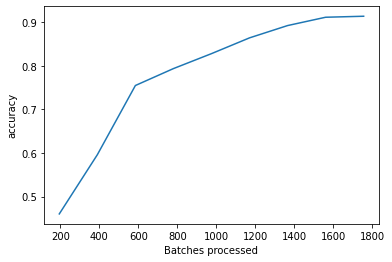

In [35]:
learner.recorder.plot_metrics()

In [33]:
torch.save(model.state_dict(), 'cifar-wrn22.pth')